绘制边界

In [7]:
import numpy as np
from scipy.spatial import Delaunay
import shapely.geometry as geometry
from shapely.ops import cascaded_union, polygonize
from scipy.spatial import distance
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box, MultiPolygon
from shapely.geometry import Polygon, MultiPolygon
from shapely.geometry import Point
from shapely.ops import unary_union
import time

def alpha_shape(points, alpha=0.1):
    """
    Compute the alpha shape (concave hull) of a set of points.
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the gooeyness of the border.
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense in computing an alpha shape.
        return geometry.MultiPoint(list(points)).convex_hull

    def add_edge(edges, edge_points, coords, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add((i, j))
        edge_points.append(coords[[i, j]])

    coords = np.array([point for point in points])
    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.simplices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]
        # Lengths of sides of triangle
        a = distance.euclidean(pa, pb)
        b = distance.euclidean(pb, pc)
        c = distance.euclidean(pc, pa)
        # Semiperimeter of triangle
        s = (a + b + c) / 2.0
        # Area of triangle by Heron's formula
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)
        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0 / alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)
    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    return cascaded_union(triangles), edge_points

# 示例点集
points = np.random.rand(100, 2)  # 示例数据，替换为您的boundary_points
alpha = 0.1  # α值，需要根据实际情况调整

concave_hull, edge_points = alpha_shape(points, alpha=alpha)


# 此处可以绘制结果或进一步处理


C:\Users\98398\AppData\Local\Temp\ipykernel_32700\4061717385.py:62: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  return cascaded_union(triangles), edge_points


可视化

In [8]:
def visualize_space(merged_rectangles, ax, color='blue'):
    # 如果是单个 Polygon，将其放入一个列表中
    if isinstance(merged_rectangles, Polygon):
        merged_rectangles = [merged_rectangles]
    # 如果是 MultiPolygon，提取每个 Polygon
    elif isinstance(merged_rectangles, MultiPolygon):
        merged_rectangles = [polygon for polygon in merged_rectangles.geoms]

    # 绘制并填充每个多边形
    for polygon in merged_rectangles:
        x, y = polygon.exterior.xy
        ax.fill(x, y, color=color, alpha=0.5)  # 填充外部多边形

        for interior in polygon.interiors:
            x, y = interior.xy
            ax.fill(x, y, color='white', alpha=1)  # 使用白色填充内部多边形以创建空洞效果

集体例子

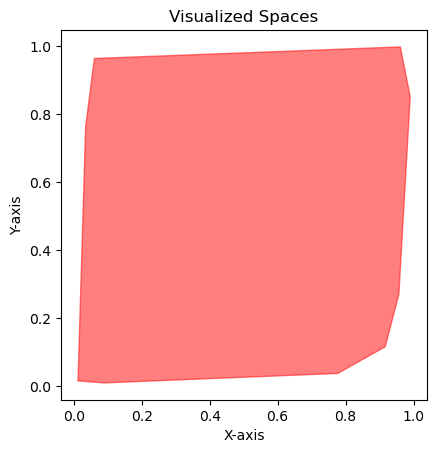

In [11]:
fig, ax = plt.subplots()
visualize_space(concave_hull, ax, color='red')    # 外部空间为红色


# 设置图像的x和y边界
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Visualized Spaces')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()